In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from pyabc.examples import mv_gauss
from pyabc.plots import plot_marginals, plot_pairs

### Multivariate Gaussian Example

### per hand

## Closed-form posterior
For a 2-dimensional Gaussian prior with mean $\mu_0$ and covariance $\Sigma_0$ and data with mean $\bar{x}$ and covariance $\Sigma$ (generated by sampling from a 2-dimensional Gaussian, whose variance we assume to be known), the posterior parameters can be derived in closed form (https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf):

$$ \Sigma_N = (\Sigma_0^{-1} + N \Sigma^{-1})^{-1}$$
$$ \mu_N = \Sigma_N (N \Sigma^{-1} \bar{x} + \Sigma_0^{-1} \mu_0) $$

In [2]:
np.random.seed(1337)

# data parameters
mu = np.array([5.0, 7.0])
sigma = np.array([[2,0.5],[0.5,1]])
N = 10

# generate some data
x = np.random.multivariate_normal(mu, sigma, N)

In [3]:
# prior parameters

mu0 = np.array([4.0, 4.0])
sigma0 = np.array([[1,-0.5],[-0.5,0.7]])
prior_mu =  pyabc.Prior('multivariate_gaussian', mu0, sigma0, name='mu')

simulator = mv_gauss.simulator

simulator(*prior_mu.sample())

array([[ 7.18258013,  3.50493722],
       [ 3.47112353,  2.44977657],
       [ 5.98410157,  0.72031324],
       [ 5.7360292 ,  3.27906882],
       [ 3.54611401,  1.44157793],
       [ 3.76061403,  1.50321353],
       [ 4.60454871,  2.79452572],
       [ 4.3638949 ,  3.78134933],
       [ 5.1014169 ,  3.45820529],
       [ 3.82215424,  1.60985239]])

In [4]:
# distance measure between sufficient statistics of two data sets
mean, cov = mv_gauss.summaries

def bhatt(s1, s2):
    mu1 = np.array([s1[0], s1[1]])
    sigma1 = np.array([[s1[2], s1[3]], [s1[4], s1[5]]])

    mu2 = np.array([s2[0], s2[1]])
    sigma2 = np.array([[s2[2], s2[3]], [s2[4], s2[5]]])
    # compute sufficient statistics (mean and covariance)
    sigma = 0.5 * (sigma1 + sigma2)
    da = 0.125 * (mu1 - mu2).T @ np.linalg.inv(sigma) @ (mu1 - mu2)
    db = 0.5 * np.log(np.linalg.det(sigma) / np.sqrt(np.linalg.det(sigma1) * np.linalg.det(sigma2)))
    return da + db

In [5]:
mean(x)

array([ 4.81463225,  6.27661113])

In [6]:
rej_samp = pyabc.RejectionSampler(
    priors=prior_mu,
    simulator=simulator,
    summaries=[mean, cov],
    distance=bhatt,
    observation=x
)

smc_samp = pyabc.SMCSampler(
    priors=prior_mu,
    simulator=simulator,
    summaries=[mean, cov],
    distance=bhatt,
    observation=x
)

In [7]:
rej_samp.sample(threshold=0.1, nr_samples=100)

Rejection sampler started with threshold: 0.1 and number of samples: 100
Samples:    100 - Threshold: 0.1000 - Iterations:      33000 - Acceptance rate: 0.003030 - Time:    11.66 s


<IPython.core.display.Javascript object>


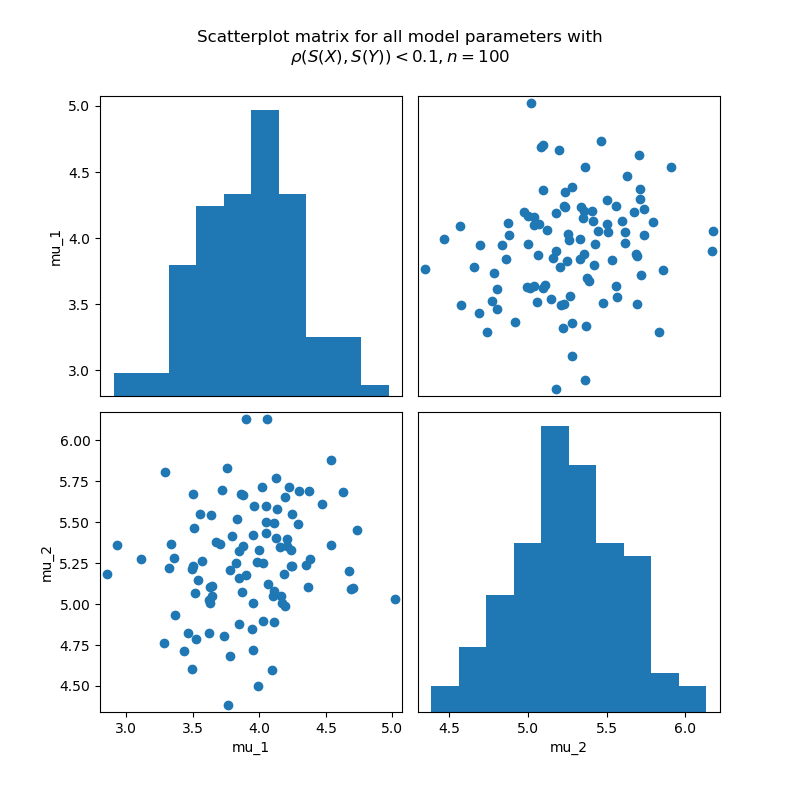

In [8]:
f = plot_pairs(rej_samp)

In [8]:
smc_samp.sample(thresholds=[5, 1, 0.1], nr_samples=100)

SMC sampler started with thresholds: [5, 1, 0.1] and number of samples: 100
Iteration 0 completed
starting iteration[ 1 ]
Iteration 1 completed
starting iteration[ 2 ]
Iteration 2 completed
Samples:    100 - Thresholds: 0.10 - Iterations:      10070 - Acceptance rate: 0.009930 - Time:     7.75 s


<IPython.core.display.Javascript object>


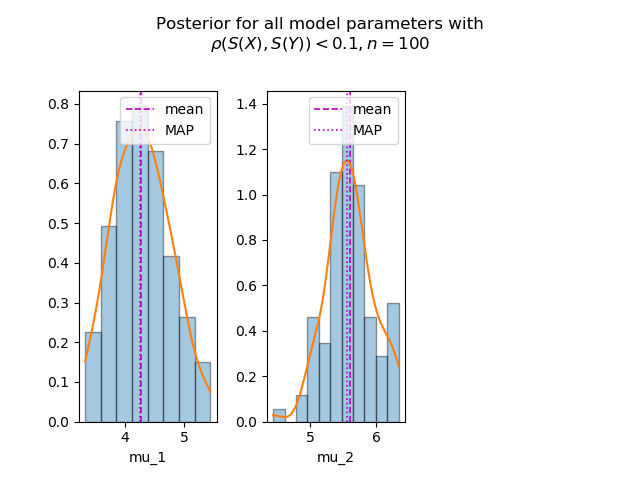

In [22]:
plot_marginals(smc_samp, kde=True)